# Exploring the Cityscapes dataset

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import pickle
from tdt17_project.data import get_dataset
import torchvision.transforms as transforms
from tqdm import tqdm
from tdt17_project.utils import decode_segmap, encode_segmap
from tdt17_project.data import apply_albumentations, get_albumentations_transform_function
import albumentations as A
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:

dataset = get_dataset("../../datasets/Cityscapes/")
val = get_dataset("../../datasets/Cityscapes/", "val")

In [80]:
len(dataset)

2975

In [81]:
len(val)

500

## Intro

In this notebook we will explore the Cityscapes dataset. The goal is to get a better understanding of the dataset to make better decisions when training the model.

We will explore the following
1. See some samples of images and masks
2. See the distribution of classes in the dataset
3. See how different data augmentation strategies can affect the dataset

In [82]:
def show_image(image):
    plt.imshow(image)
    plt.axis("off")

In [83]:
sample1 = dataset[0]
sample1

(<PIL.Image.Image image mode=RGB size=2048x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>)

## 1. Samples

In [84]:
samples = [dataset[i] for i in range(0, len(dataset), len(dataset)//10)]
samples

[(<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>),
 (<PIL.Image.Image image mode=RGB size=2048x1024>,
  <PIL.PngIma

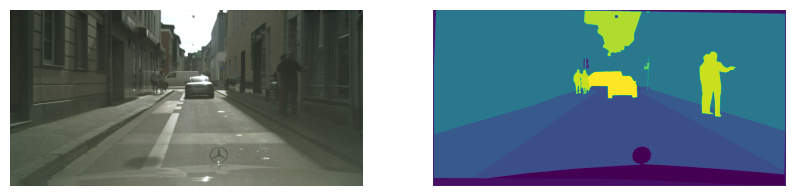

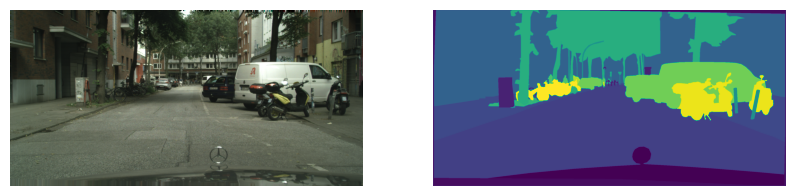

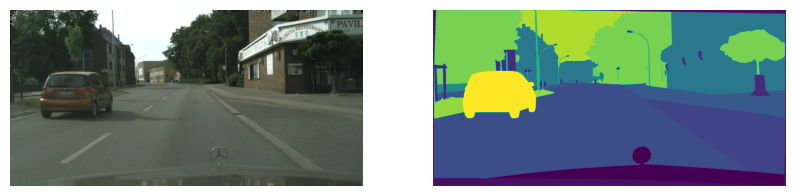

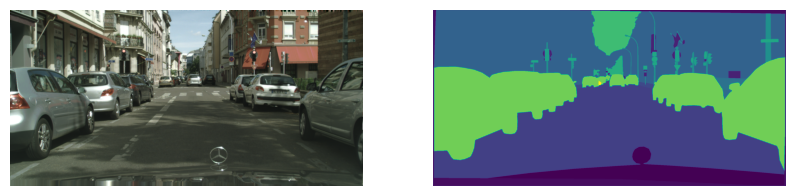

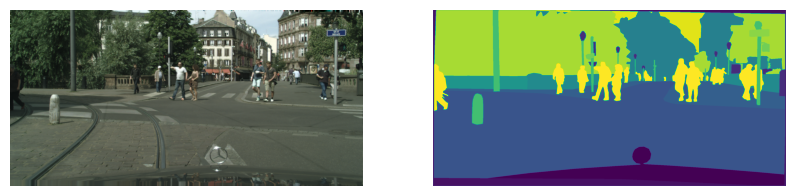

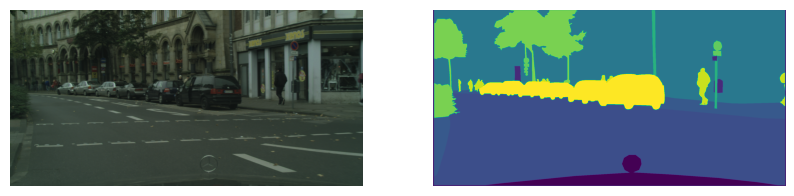

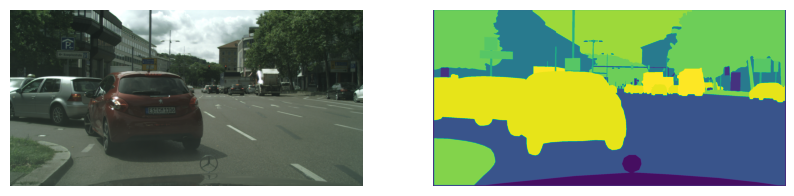

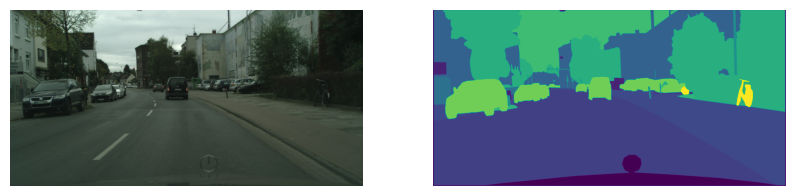

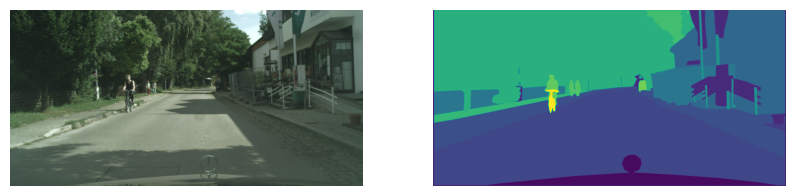

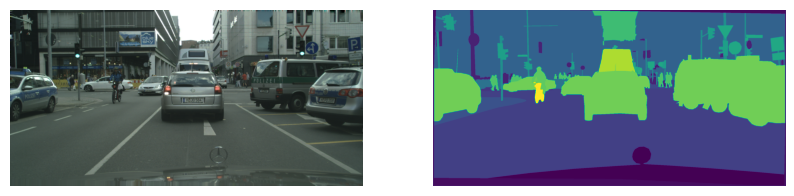

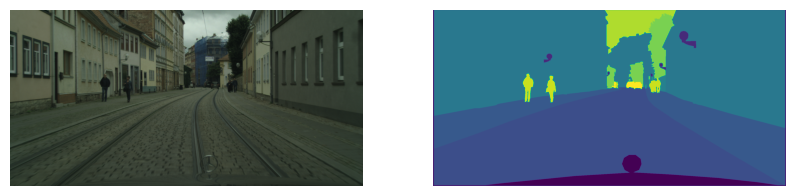

In [85]:
def show_samples(input_samples):
    for sample in input_samples:
        _, ax= plt.subplots(ncols=2, figsize=(10, 10))
        ax[0].imshow(sample[0])
        ax[1].imshow(sample[1])
        ax[0].axis("off")
        ax[1].axis("off")
    plt.show()
show_samples(samples)

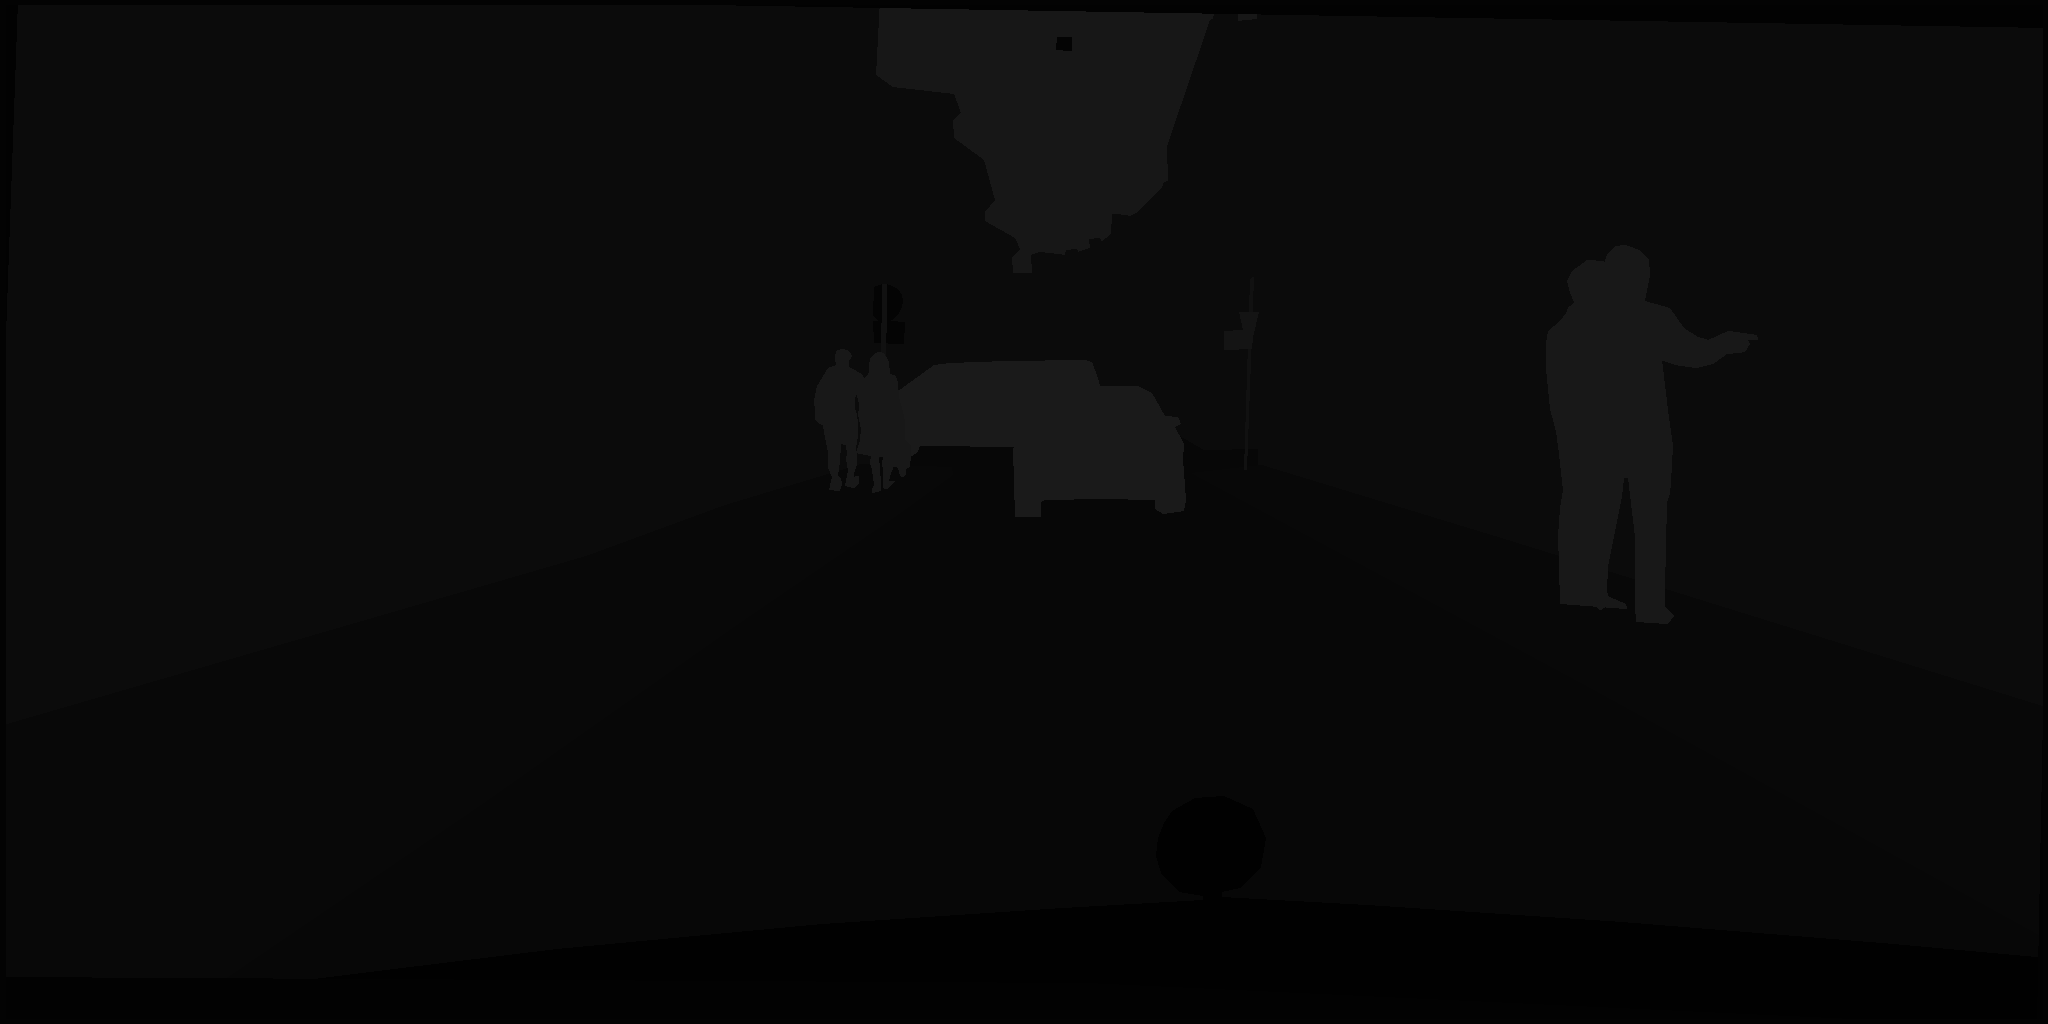

In [86]:
# The raw mask
dataset[0][1]

## 2. Class distribution


In [87]:
def get_class_distribution(cityscapes_dataset):
    try:
        with open("class_distribution.pkl", "rb") as f:
            dic = pickle.load(f)
            print("Found file")
            return dic
    except FileNotFoundError:
        print("Could not find class distribution file. Calculating...")
        class_distribution = {}

        # Iterate through the dataset to count class occurrences.
        for i in tqdm(range(len(cityscapes_dataset))):
            _, mask = cityscapes_dataset[i]
            unique_labels = np.unique(np.array(mask))
            for label in unique_labels:
                class_name = cityscapes_dataset.classes[label].name
                if class_name not in class_distribution:
                    class_distribution[class_name] = 1
                else:
                    class_distribution[class_name] += 1
                #print(class_name)
        return class_distribution
class_distribution = get_class_distribution(dataset)

Found file


In [88]:
class_distribution

{'ego vehicle': 2975,
 'rectification border': 1098,
 'out of roi': 2975,
 'static': 2945,
 'road': 2934,
 'sidewalk': 2811,
 'building': 2934,
 'pole': 2949,
 'traffic sign': 2808,
 'sky': 2686,
 'person': 2343,
 'car': 2832,
 'dynamic': 1365,
 'wall': 970,
 'fence': 1296,
 'vegetation': 2891,
 'traffic light': 1658,
 'rider': 1023,
 'motorcycle': 513,
 'bicycle': 1646,
 'terrain': 1654,
 'ground': 1073,
 'polegroup': 223,
 'unlabeled': 832,
 'parking': 720,
 'bus': 274,
 'bridge': 233,
 'truck': 359,
 'train': 142,
 'trailer': 72,
 'caravan': 59,
 'tunnel': 25,
 'guard rail': 19,
 'rail track': 101}

In [97]:
len(class_distribution)

34

<Axes: title={'center': 'Number of images per class'}>

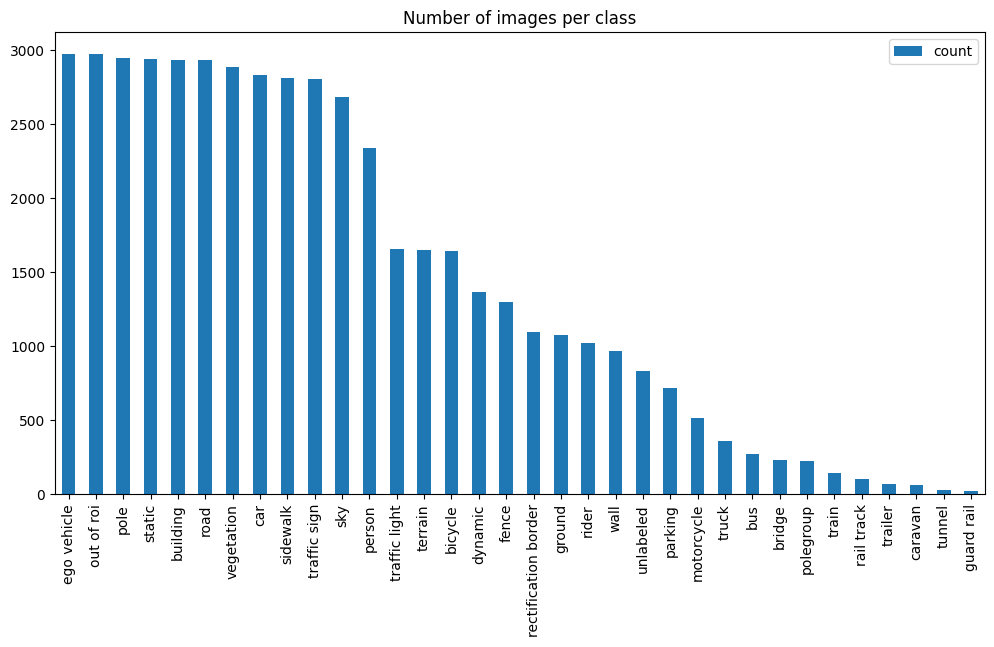

In [89]:
distrib = pd.DataFrame.from_dict(class_distribution, orient='index').rename(columns={0: 'count'})
distrib.sort_values(by="count", ascending=False).plot(kind='bar', figsize=(12, 6), title="Number of images per class")  # type: ignore

Inspired by https://github.com/talhaanwarch/youtube-tutorials/blob/main/cityscape-tutorial.ipynb
From this we can see that there are some labels that are very rare. It will be hard for the model to learn using these very rare labels. Thus, we will remove the rare labels, and some labels that could be ambiguous:
[unlabeled, ego_vehicle, rectification_border, out_of_roi, static, dynamic, ground, parking, rail_track, guard_rail, bridge, polegroup, caravan, trailer, license_plate]
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]

In [99]:
dataset.classes

[CityscapesClass(name='unlabeled', id=0, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='ego vehicle', id=1, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='rectification border', id=2, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='out of roi', id=3, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='static', id=4, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='dynamic', id=5, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(111, 74, 0)),
 CityscapesClass(name='ground', id=6, train_id=255, category='void', category_id=0, has_instances=False, i

## Exploring transforms

It is quite common to use the library `albumentations` to perform data augmentation. This library allows us to easily perform a wide variety of transformations on the images and masks. We will explore some of these transformations to see how they affect the images and masks.

# 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


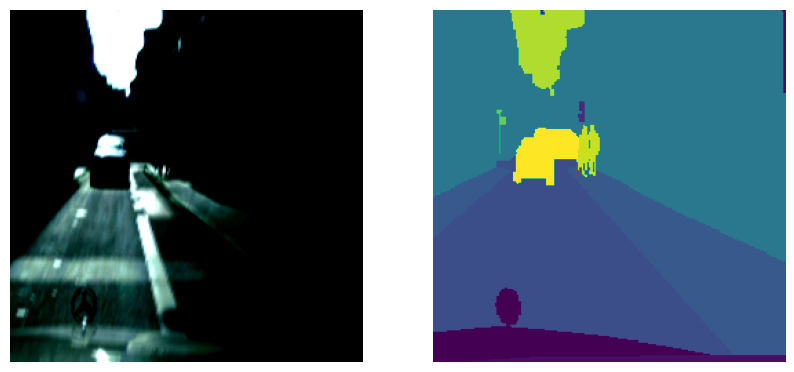

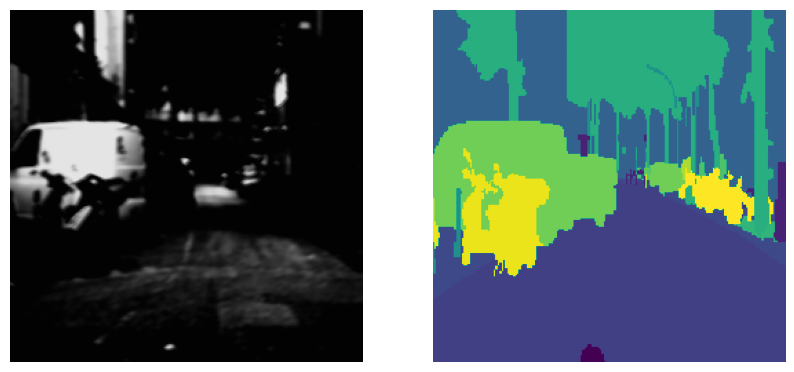

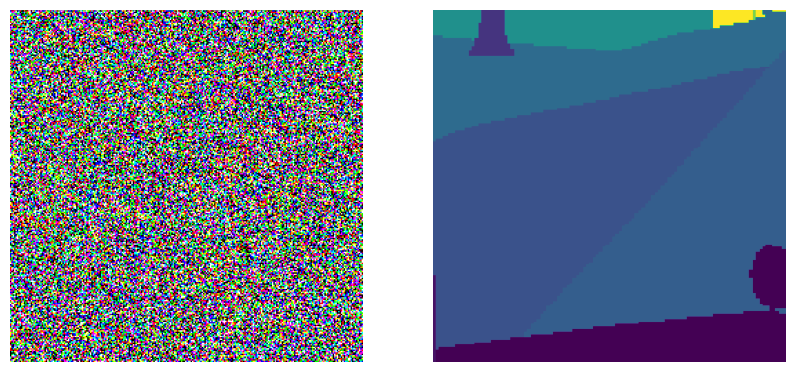

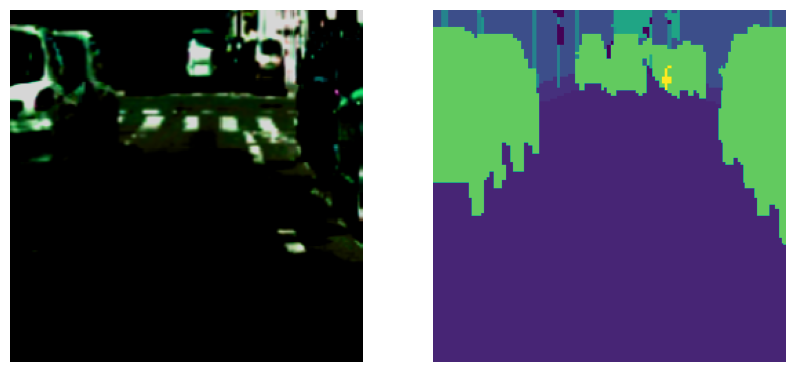

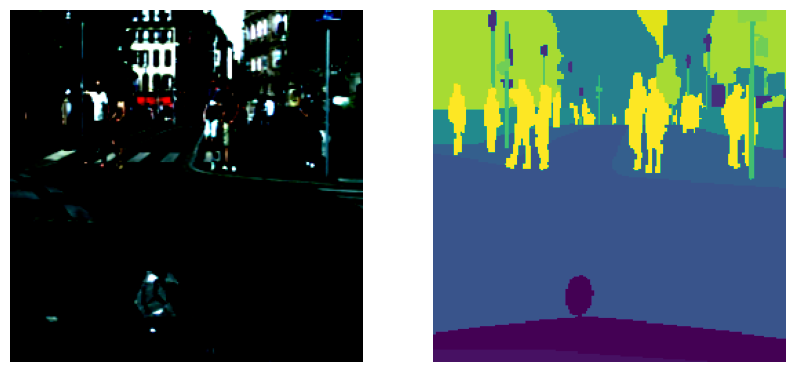

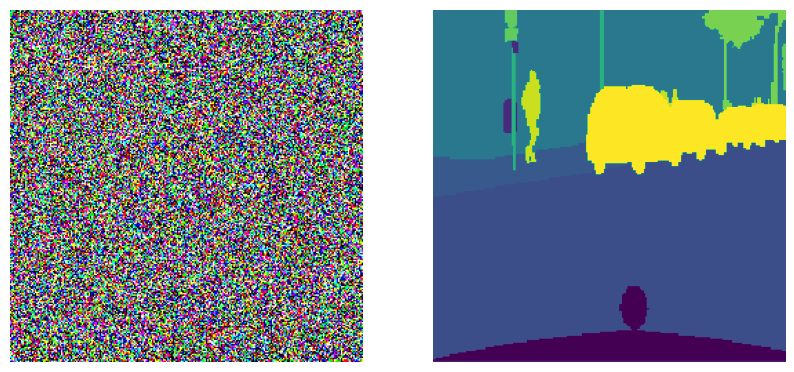

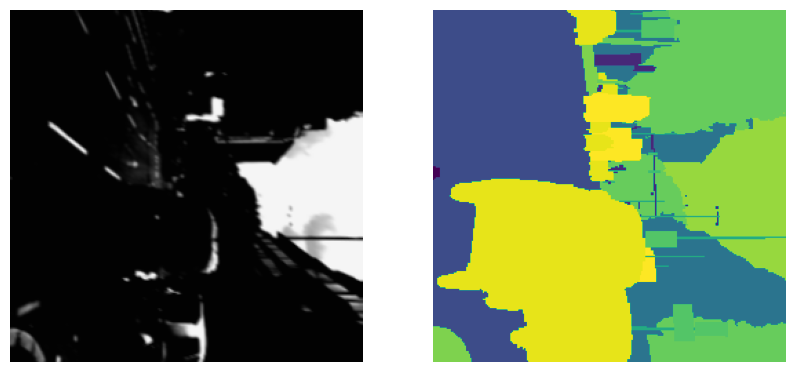

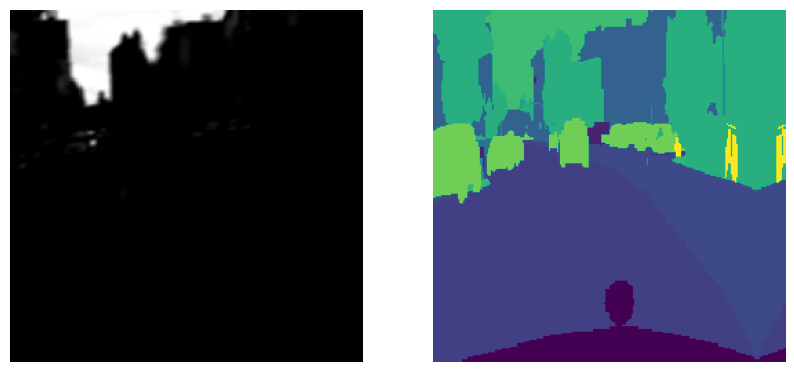

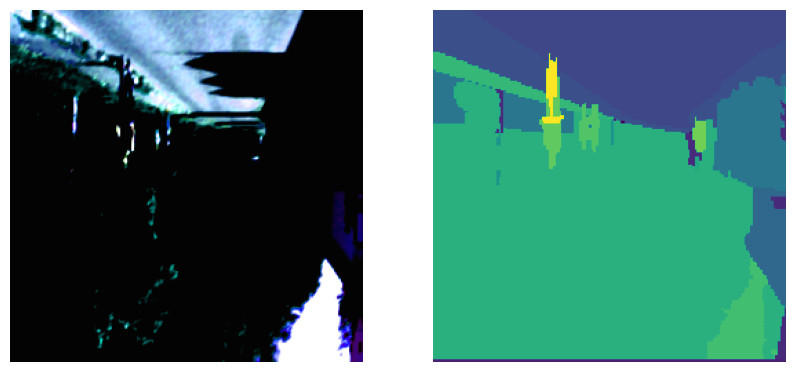

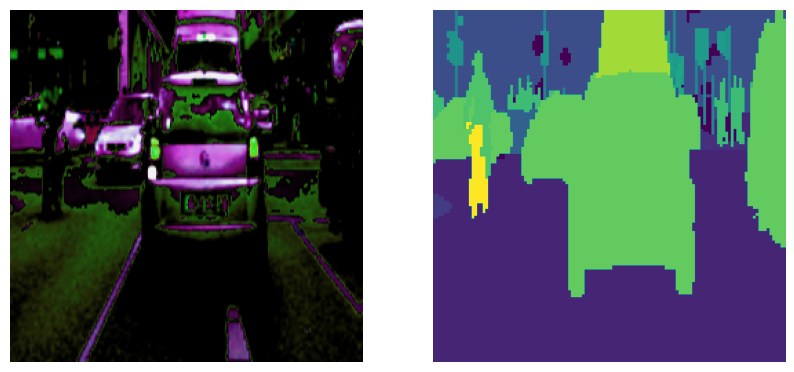

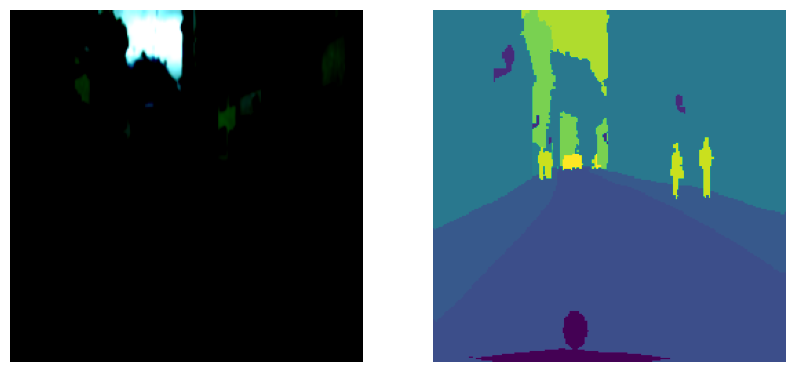

In [91]:
trans = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(),
        A.RandomResizedCrop(256, 256),
        A.RandomRotate90(),
        A.ColorJitter(),
        A.MotionBlur(p=1),
            # A.RandomRotate90(),
        A.ColorJitter(),
        A.MotionBlur(p=0.5),
        A.HorizontalFlip(),
        A.ToGray(p=0.3),
        A.OneOf(
            [
                A.GaussNoise(),
                A.OpticalDistortion(),
                A.ElasticTransform(),
                A.GridDistortion(),
                A.RandomBrightnessContrast(),
            ],
            p=0.5,
        ),
    ]
)
transformed_samples1 = [apply_albumentations(sample[0], sample[1], trans) for sample in samples]
show_samples(transformed_samples1)

As we can see here, all of these transforms together can make the image and mask look quite different It is worth noting that since the images are normalized, the below-0 values are shown as black here, while the model will be able to read these values. Thus, one should be careful when choosing which transforms to use. Using all of these transforms seems to distort the image and mask too much, despite albumentations automatically only applying non-spatial transforms (like RandomBrightnessContrast) to the image, and not the mask, to avoid changing the mask labels. It is also worth noting that random rotation is a risky augmentation, since then the model might learn that the sky can be at the bottom of the image, which is never the case. Using these values we can see that using too many destructive augmentations is bad for the model, and thus we will only use a subset of these transforms.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


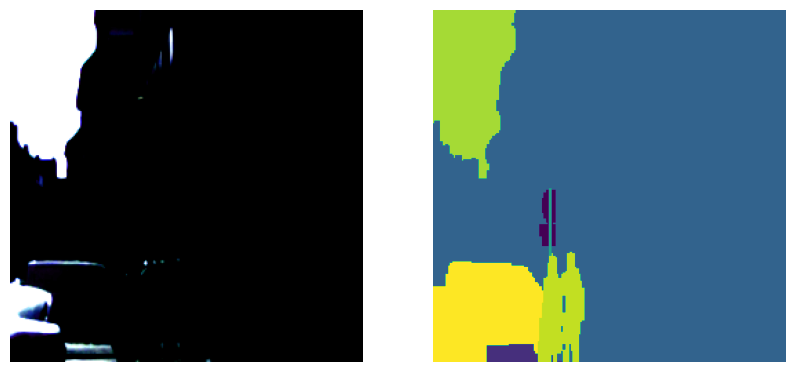

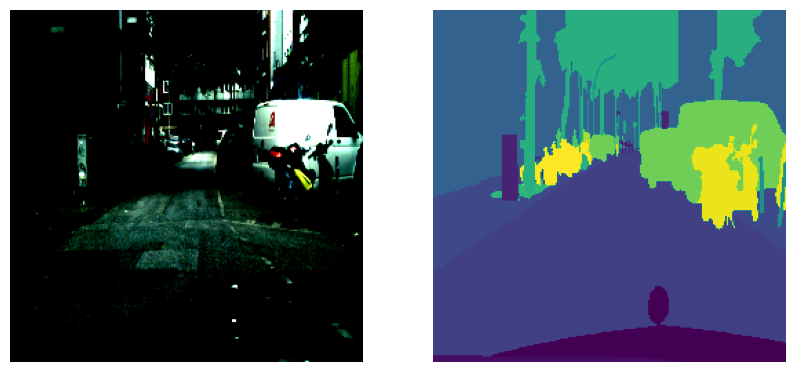

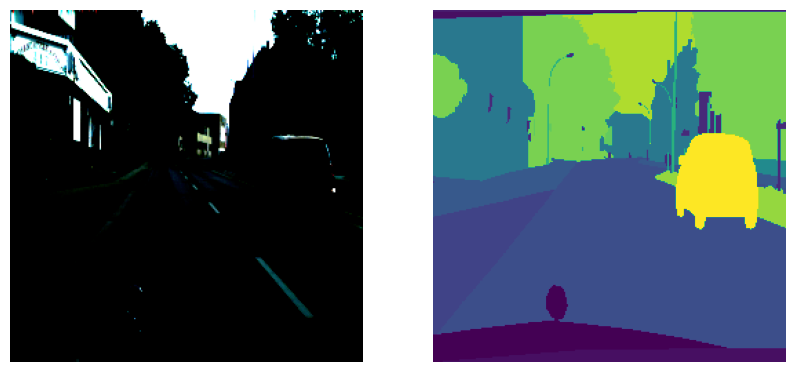

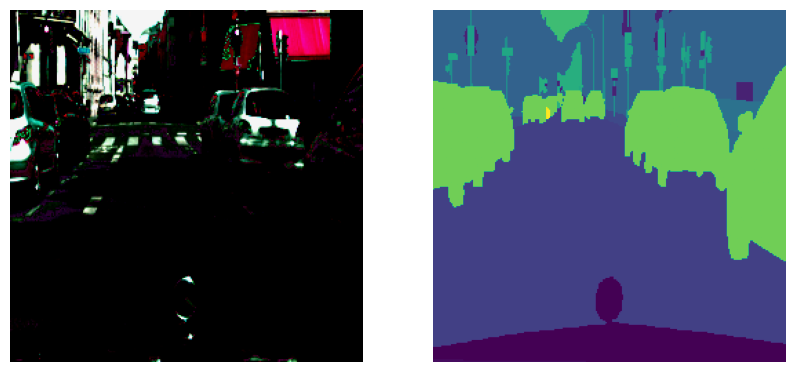

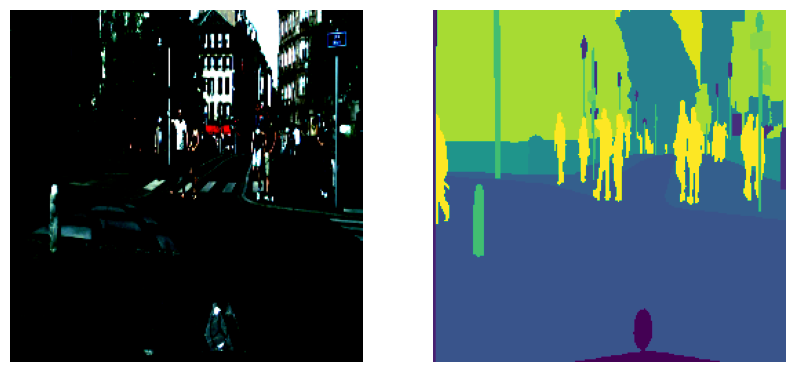

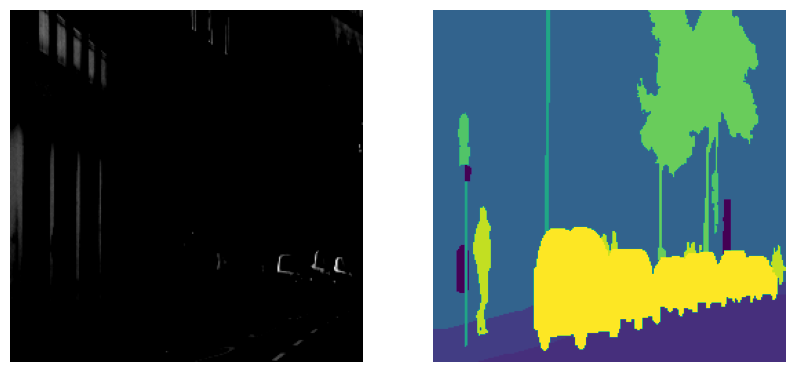

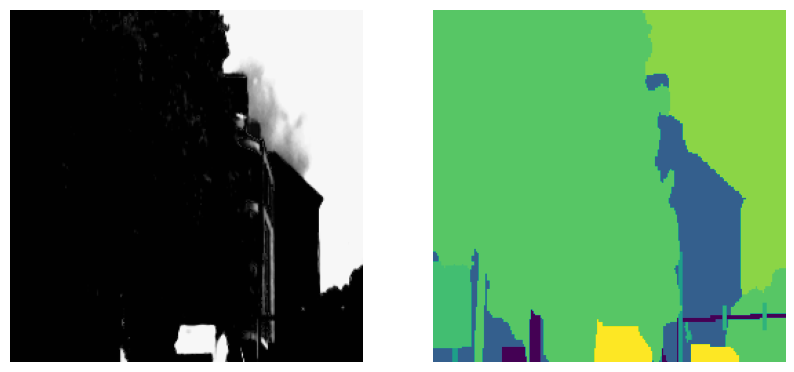

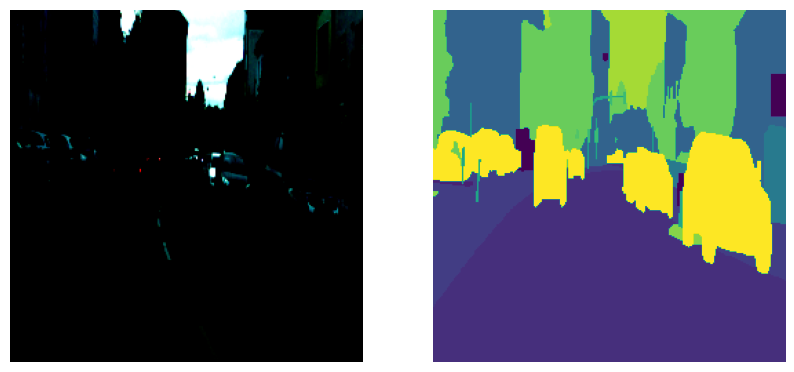

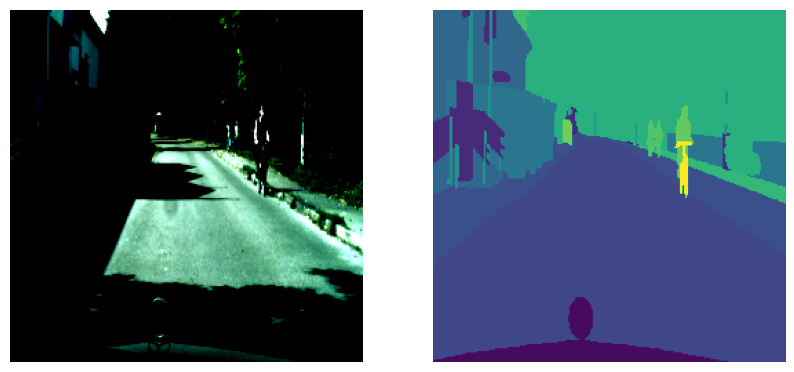

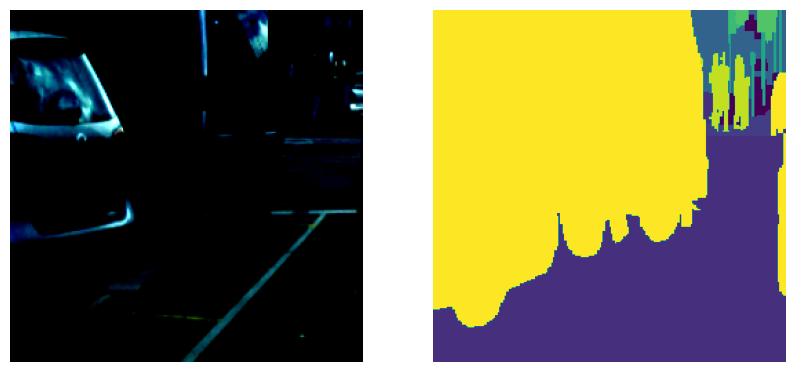

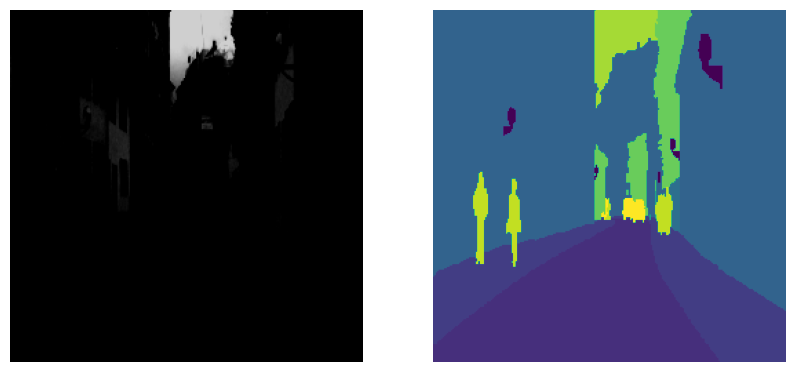

In [95]:
trans_used = A.Compose(
    [
            A.Resize(512, 512),
            A.RandomResizedCrop(256, 256),
            A.Normalize(),
            A.ColorJitter(p=0.4),
            A.HorizontalFlip(),
            A.ToGray(p=0.3),
    ]
)

transformed_samples1 = [apply_albumentations(sample[0], sample[1], trans_used) for sample in samples]
show_samples(transformed_samples1)

Here, we can see that this subset of the transforms using a small combination of non-destructive transforms and one single non-spatial, destructive transform like MotionBlur, it is a bit easier to see the objects in the image and mask. Although these transforms seems good, the model fails to learn anything using these transforms, and thus we will use a simpler suite of transforms.

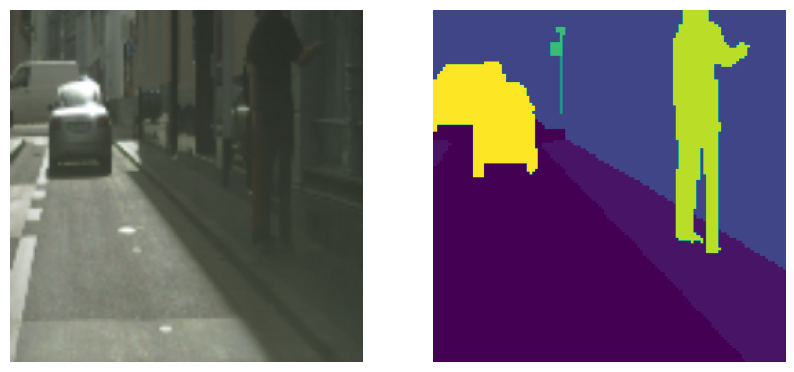

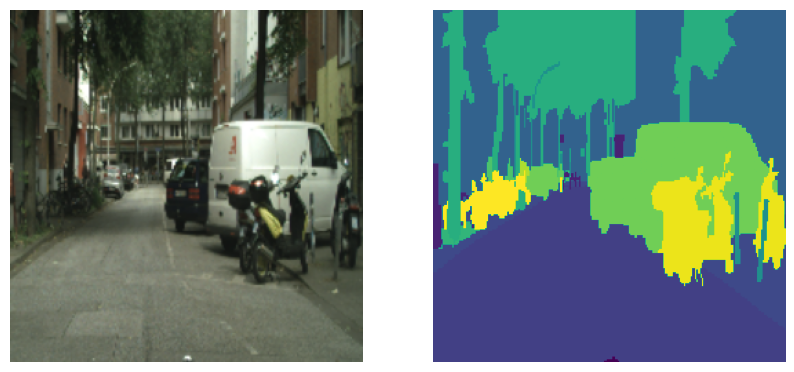

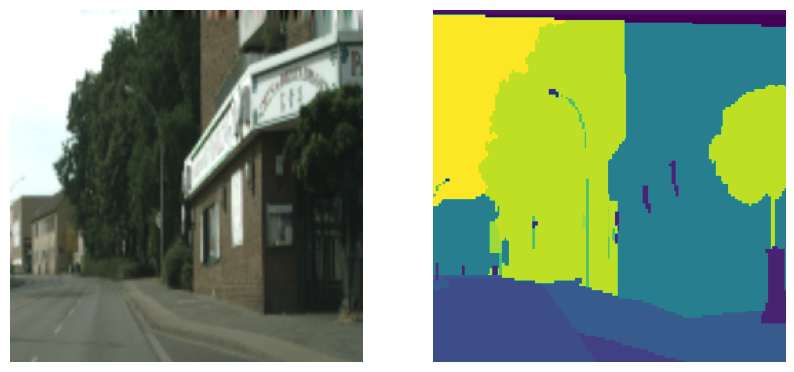

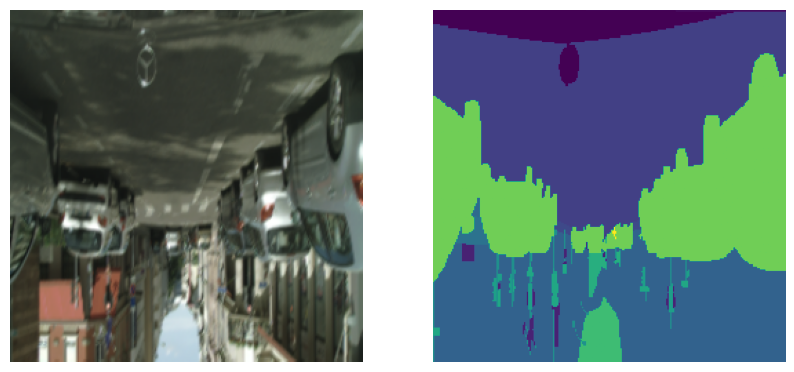

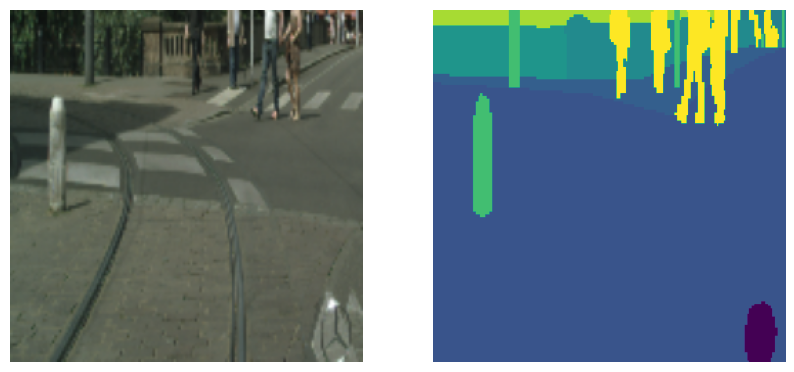

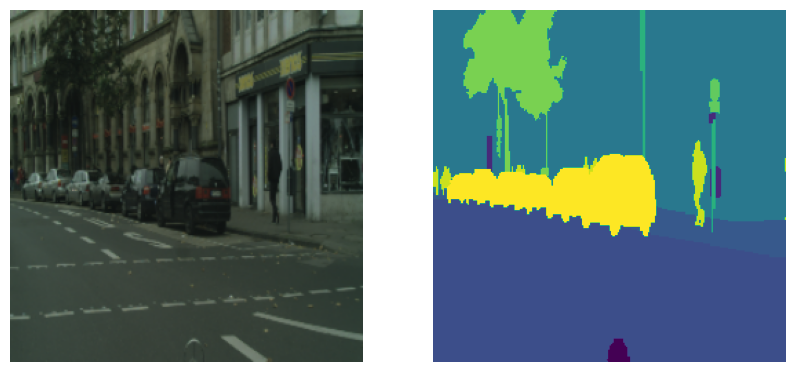

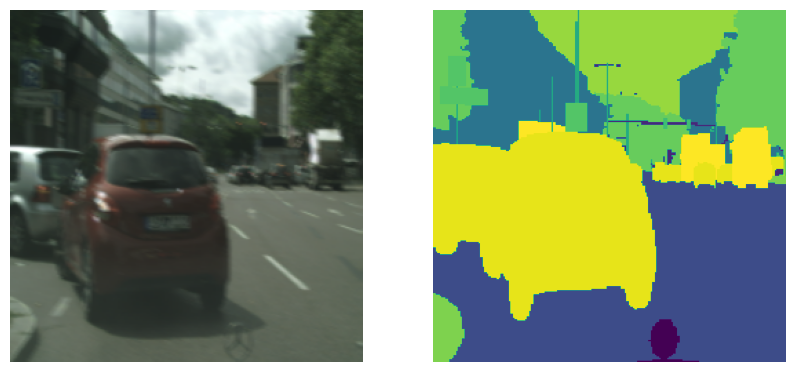

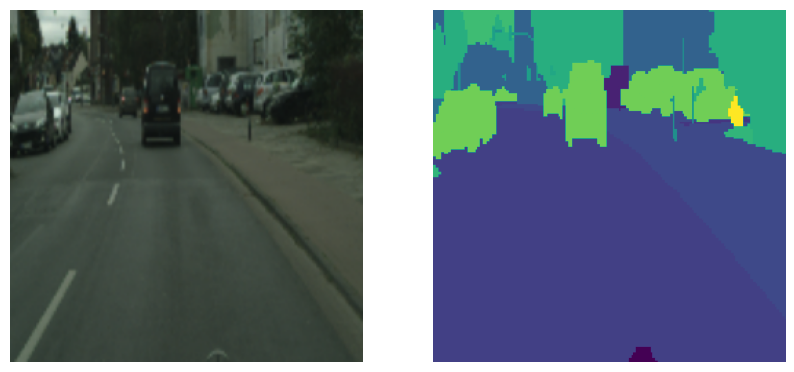

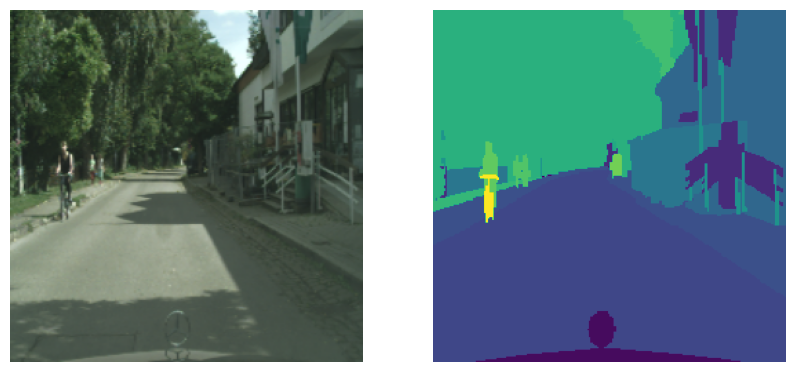

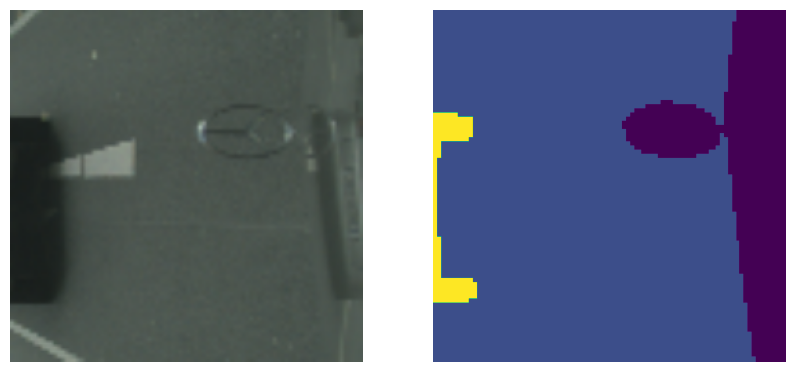

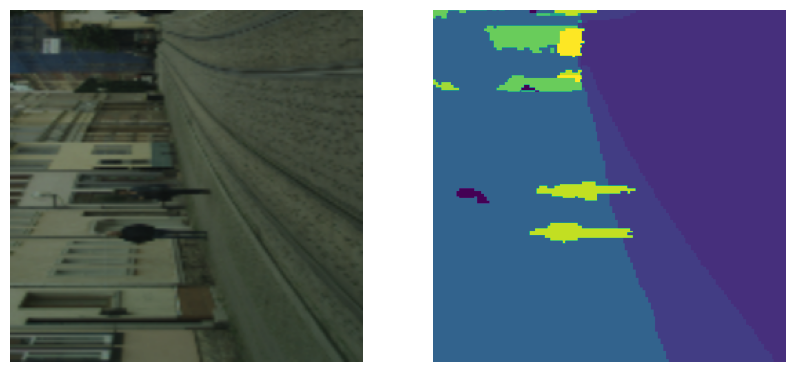

In [96]:

trans_success = A.Compose(
        [
            A.Resize(256, 256),
            A.RandomResizedCrop(256, 256),
            A.RandomRotate90(),
            A.MotionBlur(),
        ]
)

transformed_samples1 = [apply_albumentations(sample[0], sample[1], trans_success) for sample in samples]
show_samples(transformed_samples1)